In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from pyEulerCurves.distance_utils import difference_ECP
from pyEulerCurves.velocity import compute_local_contributions, projections_for_edge_2

from scipy.spatial.distance import squareform, pdist
from scipy.cluster.hierarchy import linkage, dendrogram
import os
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors


In [3]:
def save_dendrogram(
    matrix,
    labels,
    title,
    output_folder,
    jpg_name,
    orientation="right",
    method="ward",
    width=8,
    height=5,
    show=False,
    save_jpg=True,
):
    """
    Draws a dendrogram based on either a distance matrix or a feature matrix.

    Parameters
    ----------
    matrix : np.ndarray
        Either a square distance matrix or a rectangular feature matrix.
    labels : list[str]
        Labels for the objects.
    title : str
        Title of the dendrogram.
    orientation : str, optional
        Dendrogram orientation (default: 'right').
    width : float, optional
        Width of the figure in inches.
    height : float, optional
        Height of the figure in inches.
    show : bool, optional
        Whether to display the plot.
    save_jpg : bool, optional
        Whether to save the plot as a JPG file.
    """

    # Identify type of matrix
    if matrix.shape[0] == matrix.shape[1]:
        if np.allclose(matrix, matrix.T, atol=1e-10) and np.all(np.diag(matrix) == 0):
            print("Using distance matrix (squareform applied).")
            condensed_matrix = squareform(matrix)
        else:
            print("Using feature matrix (pdist computed from square input).")
            condensed_matrix = pdist(matrix, metric="euclidean")
    else:
        print("Using feature matrix (pdist computed).")
        condensed_matrix = pdist(matrix, metric="euclidean")

    # Hierarchical clustering
    Z = linkage(condensed_matrix, method=method)

    # Plot dendrogram
    fig, ax = plt.subplots(figsize=(width, height))
    dendrogram(Z, labels=labels, orientation=orientation, ax=ax)
    ax.set_title(title)
    plt.tight_layout()
    plt.xlim(left=-0.05)

    if save_jpg:
        file_path = os.path.join(output_folder, f"{jpg_name}.jpg")
        plt.savefig(file_path, format="jpg", dpi=300)

    if show:
        plt.show()

    plt.close(fig)

def process_csv(file_path):
    df = pd.read_csv(file_path)
    position_columns = [col for col in df.columns if col.startswith("s_")]
    positions = df[position_columns].to_numpy()

    velocity_columns = [col for col in df.columns if col.startswith("v_")]
    velocities = df[velocity_columns].to_numpy()

    return positions, velocities

In [4]:
# PROJECTION TEST 

positions = np.array([
    [0.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
])

velocities = np.array([
    [1.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
])

print("\nTEST 1 (aligned vectors):", projections_for_edge_2(0, 1, positions, velocities))

velocities = np.array([
    [0.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
])

print("\nTEST 2 (orthogonal vectors):", projections_for_edge_2(0, 1, positions, velocities))



TEST 1 (aligned vectors): (0.0, 2.0)

TEST 2 (orthogonal vectors): (1.0, 1.0)


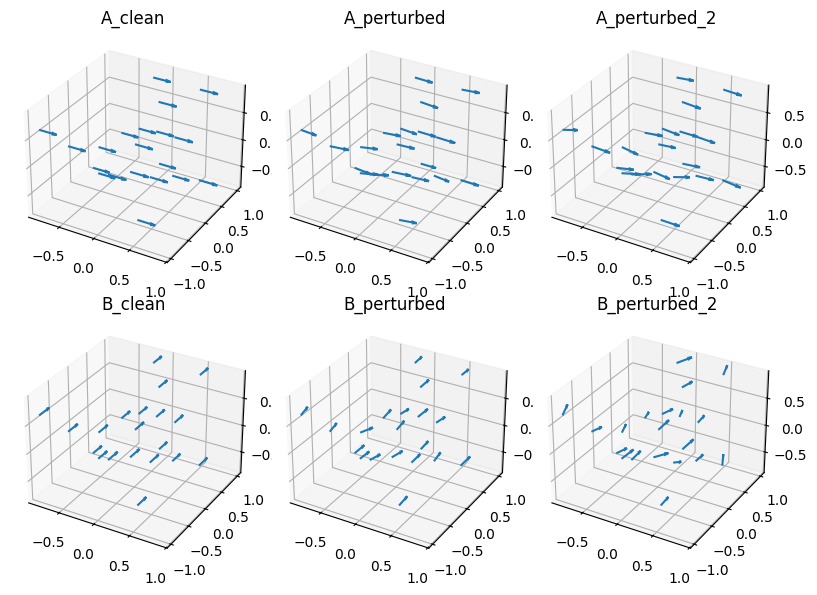

EPSILON = 0.7655447449216345


Distance matrix: 100%|██████████| 6/6 [00:00<00:00,  8.76it/s]


ECP distance matrix:
[[  0.         332.36113306 516.88034581 771.83839101 780.41841327
  799.01401369]
 [332.36113306   0.         394.64726379 836.57812118 905.37732562
  817.77368501]
 [516.88034581 394.64726379   0.         849.27026464 848.36234167
  741.60667574]
 [771.83839101 836.57812118 849.27026464   0.         281.67737255
  652.28763931]
 [780.41841327 905.37732562 848.36234167 281.67737255   0.
  651.18606574]
 [799.01401369 817.77368501 741.60667574 652.28763931 651.18606574
    0.        ]]
Using distance matrix (squareform applied).


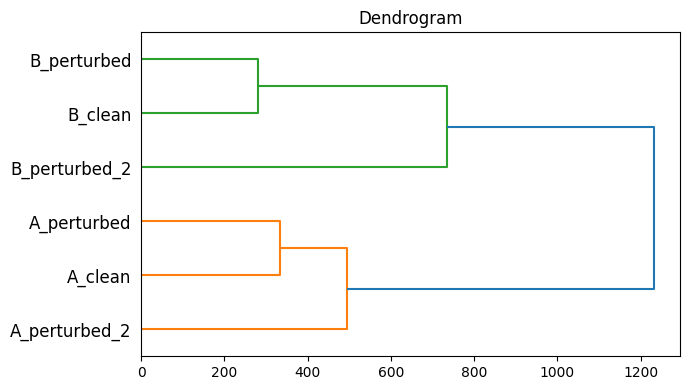

In [5]:
# CLEAN AND PERTURBED DATA
def process_csv(file_path):
    df = pd.read_csv(file_path)
    pos = df[[c for c in df.columns if c.startswith("s_")]].to_numpy()
    vel = df[[c for c in df.columns if c.startswith("v_")]].to_numpy()
    return pos, vel

def normalize(v):
    n = np.linalg.norm(v, axis=1, keepdims=True)
    n[n == 0] = 1.0
    return v / n

def field_A(p):
    v = np.zeros_like(p)
    v[:, 0] = 1.0
    return v

def field_A_perturbed(p):
    return normalize(field_A(p) + 0.1 * np.random.randn(*p.shape))

def field_A_perturbed_2(p):
    return normalize(field_A(p) + 0.2 * np.random.randn(*p.shape))

def field_B(p):
    v = np.zeros_like(p)
    v[:, 1] = 1.0
    return v

def field_B_perturbed(p):
    return normalize(field_B(p) + 0.1 * np.random.randn(*p.shape))

def field_B_perturbed_2(p):
    return normalize(field_B(p) + 0.2 * np.random.randn(*p.shape))

np.random.seed(0)

DATA_FOLDER = "data_ecp"
os.makedirs(DATA_FOLDER, exist_ok=True)

N_POINTS = 20
DIM = 3

dims = (
    (-100.0, 100.0),
    (-100.0, 100.0),
)

positions = np.random.uniform(-1, 1, size=(N_POINTS, DIM))

fields = {
    "A_clean": field_A,
    "A_perturbed": field_A_perturbed,
    "A_perturbed_2": field_A_perturbed_2,
    "B_clean": field_B,
    "B_perturbed": field_B_perturbed,
    "B_perturbed_2": field_B_perturbed_2,
}

csv_files = []
names = []

for name, fn in fields.items():
    velocities = fn(positions)

    s_cols = [f"s_{i}" for i in range(DIM)]
    v_cols = [f"v_{i}" for i in range(DIM)]

    df = pd.DataFrame(
        np.hstack([positions, velocities]),
        columns=s_cols + v_cols
    )

    path = os.path.join(DATA_FOLDER, f"{name}.csv")
    df.to_csv(path, index=False)

    csv_files.append(path)
    names.append(name)

fig = plt.figure(figsize=(8, 6))
for i, name in enumerate(names, 1):
    df = pd.read_csv(os.path.join(DATA_FOLDER, f"{name}.csv"))
    ax = fig.add_subplot(2, 3, i, projection="3d")
    ax.quiver(
        df["s_0"], df["s_1"], df["s_2"],
        df["v_0"], df["v_1"], df["v_2"],
        length=0.25,
    )
    ax.set_title(name)

plt.tight_layout()
plt.show()

pos0, vel0 = process_csv(csv_files[0])

nbrs = NearestNeighbors(n_neighbors=6).fit(pos0)
dists, _ = nbrs.kneighbors(pos0)
EPSILON = np.mean(dists[:, 1:6])

print("EPSILON =", EPSILON)

# ECP
ecp_matrix = []

for file in tqdm(csv_files, desc="Computing ECP"):
    pos, vel = process_csv(file)
    ecp, _ = compute_local_contributions(
        pos,
        vel,
        EPSILON,
        dbg=False,
    )
    ecp_matrix.append(ecp)

# DISTANCE
N = len(ecp_matrix)
ecp_difference_matrix = np.zeros((N, N))

for i in tqdm(range(N), desc="Distance matrix"):
    for j in range(i + 1, N):
        d = difference_ECP(
            ecp_matrix[i],
            ecp_matrix[j],
            dims=dims,
            verbose=False,
        )
        ecp_difference_matrix[i, j] = d
        ecp_difference_matrix[j, i] = d

print("\nECP distance matrix:")
print(ecp_difference_matrix)

# DENDROGRAM
save_dendrogram(
    ecp_difference_matrix,
    labels=names,
    title="Dendrogram",
    output_folder=DATA_FOLDER,
    jpg_name="dendrogram_minimal_test",
    width=7,
    height=4,
    show=True,
)